![alt text](https://global-uploads.webflow.com/5baafc2653bd67278f206724/5be267a03f7813daf821b31e_safegraph-logo-hidpi%403x-p-500.png)

# A Simple Method to Filter Outliers in SafeGraph Patterns

--------------
**[Ryan Fox Squire](https://www.linkedin.com/in/ryanfoxsquire/) | Product Data Scientist, [SafeGraph](https://safegraph.com/?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1)**


Dec 2019

--------------
*Share this notebook: [Shareable Link](https://colab.research.google.com/drive/1LwQNJp9qI0abUzd5jYwT_xJTHJ98iZsD#offline=true&sandboxMode=true)*



# Introduction: What to do about outliers?

Outliers are controversial. Are they bad or are they trying to tell you something? Is it an artifact (also sometimes called "contamination") or an important anomaly? Should you ignore them or make them the target your focus?

There is no one right answer. But sometimes for your business use case, it is distracting to focus on the extreme values and more important to focus on the main data. In those cases, what do we do?

**Here I show an example of when it is useful to discard outliers when building a visualization, and a simple method to handle extreme values.**

My goal is to visualize how visit duration to McDonald's varies by geographic location. I can use [SafeGraph Core Places](https://docs.safegraph.com/docs#section-core-places?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1) to get centroid locations of each McDonald's and [SafeGraph Patterns](https://docs.safegraph.com/docs/places-schema#section-patterns?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1) data (specifically the [column `median_dwell`](https://docs.safegraph.com/docs/places-manual#section--median_dwell-?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1)) for the median visit duration for each point-of-interest (POI).



In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)



# **How to use this notebook**:


---


**Quick Start:**
1. You can run this notebook using some data I've prepared.  You only need to do one thing: Run the cell below and follow the prompt to authenticate your google account (this gives you access to SafeGraph data).
2. **Everything will just run! Enjoy!**




In [ ]:
################################
# These libraries are required to read directly from SafeGraph's public GoogleDrive
# This is not necessary if you mount your own Drive directly.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################

print("Congrats, you've successfuly run this cell. \nYou are authenticated and can edit and re-run anything in the notebook. Enjoy!")

Congrats, you've successfuly run this cell. 
You are authenticated and can edit and re-run anything in the notebook. Enjoy!


In [ ]:
################################
# These functions are required to read directly from SafeGraph's Public Drive

def pd_read_csv_drive(id, drive=drive, dtype=None, thousands=None):
  downloaded = drive.CreateFile({'id':id})
  downloaded.GetContentFile('Filename.csv')
  return(pd.read_csv('Filename.csv',dtype=dtype, thousands=thousands))

drive_ids = {'core_poi-geometry-patterns.csv' : '10AT7ZDGgnZ3PC1OixSbv3UVo2F06iUkW'}
################################

# Load sample of SafeGraph Patterns & Core Places data: McDonald's Restaurants in California


In [ ]:
mcdonalds = pd_read_csv_drive(drive_ids['core_poi-geometry-patterns.csv'], dtype={'naics_code':str, 'postal_code':str,'phone_number':str})
mcdonalds = mcdonalds[mcdonalds.brands == "McDonald's"]
print(mcdonalds.shape)
mcdonalds.head()

(1277, 42)


,safegraph_place_id,parent_safegraph_place_id,safegraph_brand_ids,location_name,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,primary_number,street_predirection,street_name,street_postdirection,street_suffix,city,region,postal_code,open_hours,polygon_wkt,polygon_class,phone_number,is_synthetic,includes_parking_lot,iso_country_code,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,visitor_work_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
14,sg:b23760aeff954a06a123ad1c2ea5915a,NaN,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,McDonald's,McDonald's,Restaurants and Other Eating Places,Limited-Service Restaurants,722513,39.094091,-120.951289,501 S Auburn St,501,S,Auburn,NaN,St,Colfax,CA,95713,"{ ""Mon"": [[""5:00"", ""22:00""]], ""Tue"": [[""5:00"",...",POLYGON ((-120.9515003446606 39.09402883570249...,OWNED_POLYGON,+15303466088,False,False,US,1.569888e+09,1.572566e+09,486.0,346.0,"[21,25,14,33,29,37,31,17,3,3,1,27,16,24,17,10,...","{""060610220022"":25,""060610220023"":18,""06061022...","{""060610220022"":44,""060610218021"":5}","{""US"":343}",47722.0,11.0,"{""<5"":23,""5-20"":302,""21-60"":84,""61-240"":38,"">2...","{""IHOP"":11,""Jamba"":10,""In-N-Out Burger"":7,""Ros...","{""Chevron"":33,""Starbucks"":31,""76"":30,""ARCO"":29...","[3,4,3,4,6,9,24,27,39,45,53,70,92,72,66,73,66,...","{""Monday"":78,""Tuesday"":67,""Wednesday"":49,""Thur...","{""android"":188,""ios"":158}"
45,sg:426624b969104952a01f0422bae44e6e,NaN,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,McDonald's,McDonald's,Restaurants and Other Eating Places,Limited-Service Restaurants,722513,34.186398,-118.457058,14850 Victory Blvd,14850,NaN,Victory,NaN,Blvd,Van Nuys,CA,91411,"{ ""Mon"": [[""6:00"", ""12:00""]], ""Tue"": [[""5:00"",...","POLYGON ((-118.457164 34.186487, -118.457062 3...",OWNED_POLYGON,+18189978120,False,False,US,1.569888e+09,1.572566e+09,1692.0,979.0,"[55,37,53,74,39,46,55,70,38,38,52,48,62,49,49,...","{""060371283022"":47,""060371283032"":23,""06037128...","{""060371278061"":38,""060371288023"":15,""06037132...","{""US"":940}",4989.0,12.0,"{""<5"":58,""5-20"":964,""21-60"":321,""61-240"":178,""...","{""7-Eleven"":9,""ARCO"":8,""The Home Depot"":7}","{""Starbucks"":34,""ARCO"":33,""Subway"":31,""7-Eleve...","[181,160,153,149,155,160,165,178,209,181,174,1...","{""Monday"":222,""Tuesday"":295,""Wednesday"":264,""T...","{""android"":506,""ios"":474}"
50,sg:6dddff2354414bd38d0799fa68eb77ef,NaN,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,McDonald's,McDonald's,Restaurants and Other Eating Places,Limited-Service Restaurants,722513,34.051160,-118.279212,2020 W Olympic Blvd,2020,W,Olympic,NaN,Blvd,Los Angeles,CA,90006,"{ ""Mon"": [[""5:00"", ""23:00""]], ""Tue"": [[""5:00"",...","POLYGON ((-118.279233 34.051284, -118.279076 3...",OWNED_POLYGON,+12133894986,False,False,US,1.569888e+09,1.572566e+09,935.0,646.0,"[22,26,17,24,25,33,21,26,29,21,29,28,39,17,31,...","{""060372095202"":18,""060372095201"":12,""06037209...","{""060372095201"":9,""060372260021"":8,""0603721112...","{""US"":602}",5342.0,12.0,"{""<5"":40,""5-20"":564,""21-60"":171,""61-240"":111,""...","{""76"":9,""7-Eleven"":6}","{""Starbucks"":35,""76"":31,""7-Eleven"":29,""Jack in...","[59,33,42,49,42,53,82,86,81,83,80,88,119,100,8...","{""Monday"":115,""Tuesday"":145,""Wednesday"":161,""T...","{""android"":411,""ios"":236}"
57,sg:0e369d8d980c4033a049a1487032ac80,NaN,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,McDonald's,McDonald's,Restaurants and Other Eating Places,Limited-Service Restaurants,722513,34.080083,-118.082304,8548 Valley Blvd,8548,NaN,Valley,NaN,Blvd,Rosemead,CA,91770,"{ ""Mon"": [[""5:00"", ""23:00""]], ""Tue"": [[""5:00"",...","POLYGON ((-118.082394 34.080129, -118.082394 3...",OWNED_POLYGON,+16265719604,False,False,US,1.569888e+09,1.572566e+09,921.0,612.0,"[29,20,23,19,34,23,28,28,26,25

I want to visualize every McDonald's on a map, and show the [`median_dwell`](https://docs.safegraph.com/docs/places-manual#section--median_dwell-?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1) as the size of the dot.

In [ ]:
def make_map_plot(df, plot_limit=10000, radius_col='raw_visit_counts', radius_mod=100, color='black', fill_color='red', fill_opacity = 0.2,  zoom_start=6, verbose=False):
    # df requires a column called "latitude" and a column called "longitude". see also: https://leafletjs.com/reference-1.3.4.html#path

    map_plot = folium.Map(location=[df.latitude.mean(), df.longitude.mean()],
                   tiles='OpenStreetMap', # Stamen Toner
                   zoom_start=zoom_start,
                  control_scale = True)

    counter = 1
    for index, row in df.iterrows():
        counter+=1
        folium.CircleMarker([row.latitude, row.longitude],
                        radius= row[radius_col]/radius_mod,
                        color = color,
                        fill_color = fill_color,
                        weight=0.5,
                        fill_opacity= fill_opacity
                   ).add_to(map_plot)
        if(counter>plot_limit): break
    if(verbose): print("Plotted {0} locations".format(counter))
    return(map_plot)


# Sometimes extreme values ("outliers") are distracting on a map




In [ ]:
print("Figure 1: \nThe center of each circle is a McDonald's in California.\nThe radius of the circle represents the median dwell time for visitors to that McDonald's.")
make_map_plot(mcdonalds, radius_col='median_dwell', radius_mod=5)

Figure 1: 
The center of each circle is a McDonald's in California.
The radius of the circle represents the median dwell time for visitors to that McDonald's.


As viewable on the map (see also the data summaries below), there is clearly something unusual about a single POI in the southern tip of California (`sg:724558c09d1c42e2b09f2ef8abe5d4ce`) that has a `median_dwell` 600x larger than the average McDonald's and 6x larger than the next largest `median_dwell`.


Summary of median_dwell:

 count    1160.000000
mean       11.073707
std        20.878928
min         5.000000
25%         8.000000
50%         9.000000
75%        10.000000
max       662.000000
Name: median_dwell, dtype: float64 

Top 5 largest median dwells:
                         safegraph_place_id location_name        street_address  median_dwell
81     sg:724558c09d1c42e2b09f2ef8abe5d4ce    McDonald's          1280 12th St         662.0
2975   sg:67e402db564a456a9adedf53f06f969d    McDonald's  31250 Bob Hope Drive         165.0
15150  sg:e45eaf34fad04abf863813877f3dd006    McDonald's    6433 Fallbrook Ave         117.5
15339  sg:74c1bc205f944069b471f5c4887a2e30    McDonald's       5900 Beach Blvd         107.5
3922   sg:526d082a8f5940d5b2d32b8e9a4bf63f    McDonald's        1201 Ocean Ave          91.0 

 
Figure 2: Histogram of median_dwell for all McDonald's in California.
Arrow shows extreme outlier.


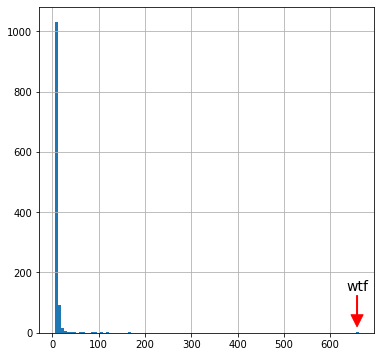

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6]

# analyze distribution
print("Summary of median_dwell:\n\n",
      mcdonalds.median_dwell.describe(),
      "\n\nTop 5 largest median dwells:\n",
      mcdonalds[['safegraph_place_id', 'location_name', 'street_address', 'median_dwell']].sort_values(by='median_dwell', ascending=False).head(),
      "\n\n",
      "\nFigure 2: Histogram of median_dwell for all McDonald's in California.\nArrow shows extreme outlier.")

# plot histogram
fig, ax = plt.subplots()
mcdonalds.median_dwell.hist(bins=100, ax=ax)
ax.annotate('wtf',
            xy=(mcdonalds.median_dwell.max()-4, 20),
            xytext=(mcdonalds.median_dwell.max()-4, 140),
            arrowprops=dict(color='red',width=1),
            horizontalalignment='center',
            size=14)
plt.show()

The goal of my map is to illustrate the variance in dwell times for all McDonald's across the state. Whether we think the extreme POI is interesting or an artifact, this one extreme value is very distracting on my map because it is so off-scale from the rest of the dataset.

We could cherry pick it and drop `sg:724558c09d1c42e2b09f2ef8abe5d4ce` from the dataset, but instead let's implement a simple, generic method for filtering out extreme values.

# A very simple method to filter extreme values

There is no one correct way to "handle" [outliers](https://en.wikipedia.org/wiki/Outlier), and sometimes outliers shouldn't be "handled" at all.

*Warning! You should always* [look at your data](https://qr.ae/TZ2xBR); *do not blindly filter "outliers" without consideration.*

Here we implement the [inter-quartile-range based method](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences) as originally formulated by John Tukey. [[1](https://en.wikipedia.org/wiki/John_Tukey)] [[2](https://stats.stackexchange.com/a/60240/78897)]. *Note: This is one of the most common definitions for "whiskers" on a [box-and-whiskers plot](https://en.wikipedia.org/wiki/Box_plot#Types)*


<img src="https://user-images.githubusercontent.com/6432906/70366127-0f0a2580-188d-11ea-86d3-1103203daed3.png" alt="ex" ALIGN="left" height=300>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

Typically the Upper Extreme is defined as the `Upper_Quartile + k * IQR` and the Lower Extreme is `Lower_Quartile - k * IQR`.

The standard is to use k = 1.5. But for the purposes of visualization you should use whatever works.





*Disclaimer! Any outlier filtering method has to make an assumption about the distribution of the data. Tukey's approach (and most others) assume gaussian data. A lot of SafeGraph patterns data is not gaussian (and may be better modeled as poisson). For more info on this see [this Cross Validated thread](https://stats.stackexchange.com/questions/13086/is-there-a-boxplot-variant-for-poisson-distributed-data)*.

Here we will keep it simple and assume gaussian.

Below, the function `label_outliers_iqr` accepts a dataframe `df` and a column name `column_to_filter`. It returns a copy of the input dataframe with a new Boolean column `outlier`, defined as `True` for any outliers according to the k * IQR method.


In [ ]:
def label_outliers_iqr(df, column_to_filter, k=1.5, outlier_col='outlier', verbose=False):
  df = df.copy()
  quartiles = df[column_to_filter].quantile([.25, .75])
  iqr = np.abs(quartiles.iloc[1] - quartiles.iloc[0])
  tolerable_range = pd.Series([quartiles.iloc[0] - k*iqr - 0.01, quartiles.iloc[1] + k*iqr + 0.01 ])
  df[outlier_col] = (df[column_to_filter].isna() | df[column_to_filter].clip(*tolerable_range).isin(tolerable_range)) # clip sets values outside the range equal to the boundaries

  if(verbose):
    num_nullvalues = df[column_to_filter].isna().sum()
    num_outliers = df[outlier_col].sum() - num_nullvalues
    print("Found {0} null values and {1} outliers.".format(num_nullvalues, num_outliers))
  return(df)


Let's try it.
In the cell below, you can adjust the `outlier_tolerance_k` variable to include or exclude more or fewer extreme values.

You can compare the distribution before and after, and compare the map of the filtered data to the original map above.

Note that unless you choose k=1.5, then there will still be data points outside the whiskers of hte boxplot. In my case I want to include some of these unusual points on my map; so I am choosing a much more inclusive k value.

Found 117 null values and 14 outliers.


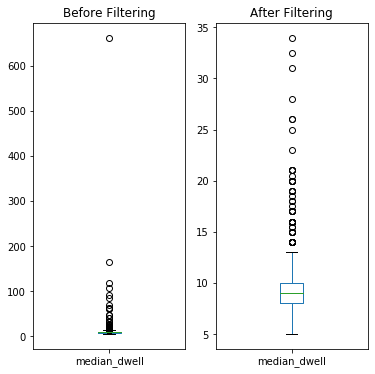

In [ ]:
column2plot = 'median_dwell'
outlier_tolerance_k = 12 # larger means you tolerate more extreme values. For gaussian data, standard is 1.5.

mcdonalds_labeled = label_outliers_iqr(mcdonalds, column2plot, k=outlier_tolerance_k, outlier_col='outlier', verbose=True)
filtered_mcdonalds = mcdonalds_labeled[~mcdonalds_labeled['outlier']]

# Plot before and after
fig, axes = plt.subplots(ncols=2)
mcdonalds[column2plot].plot.box(ax=axes[0])
filtered_mcdonalds[column2plot].plot.box(ax=axes[1])
axes[0].title.set_text("Before Filtering")
axes[1].title.set_text("After Filtering")
plt.show()

# make new map
make_map_plot(filtered_mcdonalds, radius_col=column2plot, radius_mod=1)

Now this map is much more interesting to explore and better illustrates the differences across locations. Note that you can click-drag and zoom in and out to move the map and adjust the zoom-scale. Look around!

For example, in Northern California, the McDonald's with one of the largest median dwell times is located in the high-tourist area of downtown San Francisco's Union Square.

In [ ]:
data2map = df[ (~df['outlier']) & (df['city']=='San Francisco')]
make_map_plot(data2map, radius_col=column2plot, radius_mod=1, zoom_start=12)



---

*Thanks for reading! If you found this useful or interesting please upvote and share with a friend.*

*You are strongly encouraged to try out a sample of ***SafeGraph Core Places and Patterns*** data for free, no strings attached at the [SafeGraph Data Bar](https://shop.safegraph.com/?utm_source=content&utm_medium=referral&utm_campaign=colabnotebook&utm_content=colab_patterns_outlier1).*  *Use coupon code* **`FilterOutliersTheSimpleWay`** *for $200 worth of free data!*

---

Contact:
* Please send us your ideas, feedback, bug discoveries, and suggestions: datastories@safegraph.com
* Or leave us a comment on the blog